In [1]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD,RMSprop
from keras.callbacks import *
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
import os,sys
import pickle
sys.path.append('/home/cs341seti/cs341-ibm-seti/')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import re
import collections
import sklearn
import scipy
import commonutils as cu
import model_specs
from sklearn import svm
from sklearn.externals import joblib

# Older Experimentation

In [44]:
## Loading in stuff 
fileListDF = pd.read_csv('../data/fileList.csv',dtype={'file_index':str})
fileListDF.head()
fileListDF[fileListDF['signal_classification']=='narrowbanddrd'].head()

,file_name,signal_classification,uuid,file_index,label,dataset
2,000874dd-8d6e-44b1-8ade-21aeb5a29546.dat,narrowbanddrd,000874dd-8d6e-44b1-8ade-21aeb5a29546,000002,3,train
15,0033dd64-1b34-4821-ba47-56dcf2569e56.dat,narrowbanddrd,0033dd64-1b34-4821-ba47-56dcf2569e56,000015,3,train
18,003a05f0-b882-4be1-81a0-bf52cd8becaf.dat,narrowbanddrd,003a05f0-b882-4be1-81a0-bf52cd8becaf,000018,3,train
20,003f73ec-4ece-4223-a814-e160b9106ca4.dat,narrowbanddrd,003f73ec-4ece-4223-a814-e160b9106ca4,000020,3,train
27,00530249-7d11-43b1-a92c-d7b8fc3db995.dat,narrowbanddrd,00530249-7d11-43b1-a92c-d7b8fc3db995,000027,3,train


In [12]:
traceDataset = np.load('traceData_subset_0.2alpha.npy')

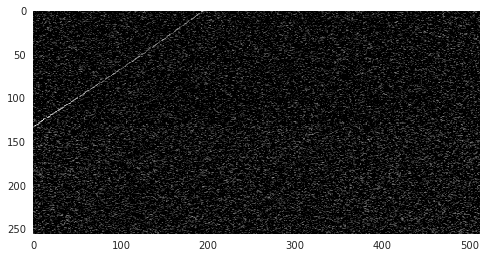

In [38]:
basepath = '../data/welch_specdataimages_gray_256x512_6/'
fid = '000054'
nid = int(fid)
x = img_to_array(load_img('{}{}.jpg'.format(basepath,fid),grayscale=True))
x = cu.modelutils.columnNormalize(x)
x = x.clip(min=0)
fig, ax = plt.subplots(1, 1)
ax.grid(False)
plt.set_cmap('gray')
ax.imshow((x[:,:,0]))
plt.show()

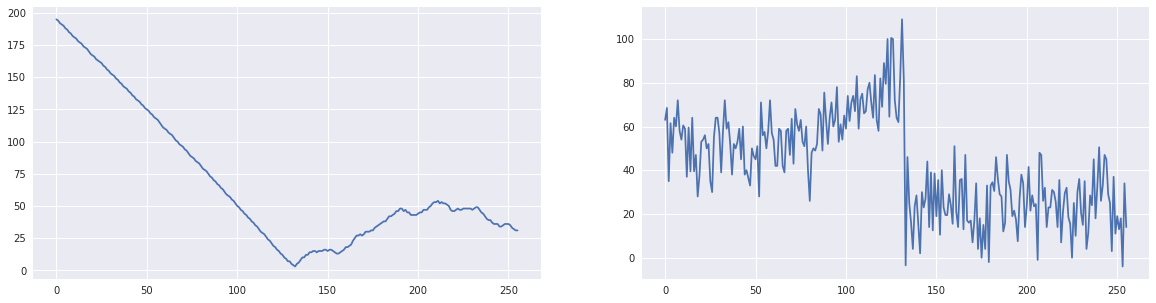

In [39]:
x_test = traceDataset[nid]
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(traceDataset[nid,:,0])
plt.subplot(122)
plt.plot(traceDataset[nid,:,1])
plt.show()

In [6]:
traceDataset.shape

(1000, 256, 2)

# Classification starts here

In [3]:
## Loading in stuff 
fileListDF = pd.read_csv('../data/fileList.csv',dtype={'file_index':str})
fileListDF.head()
fileListDF[fileListDF['signal_classification']=='narrowbanddrd'].head()

,file_name,signal_classification,uuid,file_index,label,dataset
2,000874dd-8d6e-44b1-8ade-21aeb5a29546.dat,narrowbanddrd,000874dd-8d6e-44b1-8ade-21aeb5a29546,000002,3,train
15,0033dd64-1b34-4821-ba47-56dcf2569e56.dat,narrowbanddrd,0033dd64-1b34-4821-ba47-56dcf2569e56,000015,3,train
18,003a05f0-b882-4be1-81a0-bf52cd8becaf.dat,narrowbanddrd,003a05f0-b882-4be1-81a0-bf52cd8becaf,000018,3,train
20,003f73ec-4ece-4223-a814-e160b9106ca4.dat,narrowbanddrd,003f73ec-4ece-4223-a814-e160b9106ca4,000020,3,train
27,00530249-7d11-43b1-a92c-d7b8fc3db995.dat,narrowbanddrd,00530249-7d11-43b1-a92c-d7b8fc3db995,000027,3,train


In [59]:
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,4.0:3.0,5.0:4.0,6.0:5.0}
traceDataset_01_alpha = cu.datautils.loadDataset('../data/traceDataset_0.1alpha.hdf5',subsetClasses=subsetClasses)
traceDataset_05_alpha = cu.datautils.loadDataset('../data/traceDataset_0.5alpha.hdf5',subsetClasses=subsetClasses)

Dim of data: 256
Number of training images = 10588
Number of validation images = 2097
Number of test images = 1300
Distribution in training data:
0 - 1526
1 - 1531
2 - 3018
3 - 1503
4 - 1509
5 - 1501
Distribution in validation data:
0 - 287
1 - 281
2 - 628
3 - 303
4 - 302
5 - 296
Distribution in test data:
0 - 185
1 - 185
2 - 349
3 - 192
4 - 186
5 - 203
Dim of data: 256
Number of training images = 10588
Number of validation images = 2097
Number of test images = 1300
Distribution in training data:
0 - 1526
1 - 1531
2 - 3018
3 - 1503
4 - 1509
5 - 1501
Distribution in validation data:
0 - 287
1 - 281
2 - 628
3 - 303
4 - 302
5 - 296
Distribution in test data:
0 - 185
1 - 185
2 - 349
3 - 192
4 - 186
5 - 203


# Generating features from traces

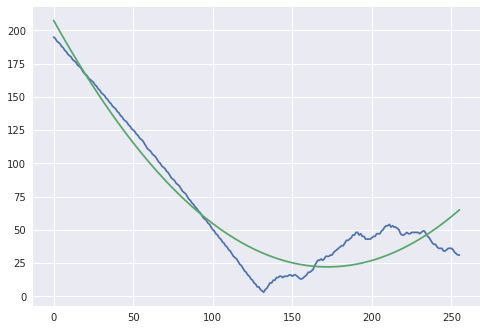

In [40]:
fit = np.polyfit(range(256),x_test[:,0],2,full=True)
f = np.poly1d(np.polyfit(range(256),x_test[:,0],2))
plt.plot(range(256),x_test[:,0])
plt.plot(range(256),f(range(256)))
plt.show()

In [75]:
# calculate poly
def generatePolynomialFeatures(traceDataset,order=2):
    features = np.zeros((traceDataset.shape[0],order+1))
    for i in range(traceDataset.shape[0]):
        x = traceDataset[i]
        poly_fit = np.polyfit(range(x.shape[0]),x[:,0],order)
        features[i,:] = poly_fit
    return features

def generateDistributionFeatures(traceDataset): 
    ncols = traceDataset.shape[2]
    features = np.zeros((traceDataset.shape[0],ncols*2))
    for i in range(traceDataset.shape[0]):
        x = traceDataset[i]
        # Total signal variation: standard deviation of differences
        # running a small moving average so that stuff doesn't get too noisy
        features[i,0:ncols] = np.apply_along_axis(
                lambda x: np.std(np.convolve(np.diff(x),np.ones((3,))/3)),0,x)
        features[i,ncols:] = scipy.stats.kurtosis(x,axis=0)
    return features

def buildFeaturesDataset(traceDatasetList):
    featuresDataset = {}
    for key in traceDatasetList[0].keys():
        if key in ['x_train','x_val','x_test']:
            featuresList = []
            for traceDataset in traceDatasetList:
                features = np.concatenate([generatePolynomialFeatures(traceDataset[key]),
                                           generateDistributionFeatures(traceDataset[key])],axis=1)
                featuresList.append(features)
            featuresDataset[key] = np.concatenate(featuresList,axis=1)
        else:
            featuresDataset[key] = traceDatasetList[0][key]
    return featuresDataset

In [76]:
# Make a dataset with features extracted
featuresDataset = buildFeaturesDataset([traceDataset_01_alpha,traceDataset_05_alpha])

In [77]:
featuresDataset['x_train'].shape

(10588, 14)

In [26]:
trainFeaturesDF = pd.DataFrame(featuresDataset['x_train'])
trainFeaturesDF['label'] = fileListDF['label'].ix[fileListDF['dataset']=='train']
trainFeaturesDF['label'] = trainFeaturesDF['label'].apply(str)

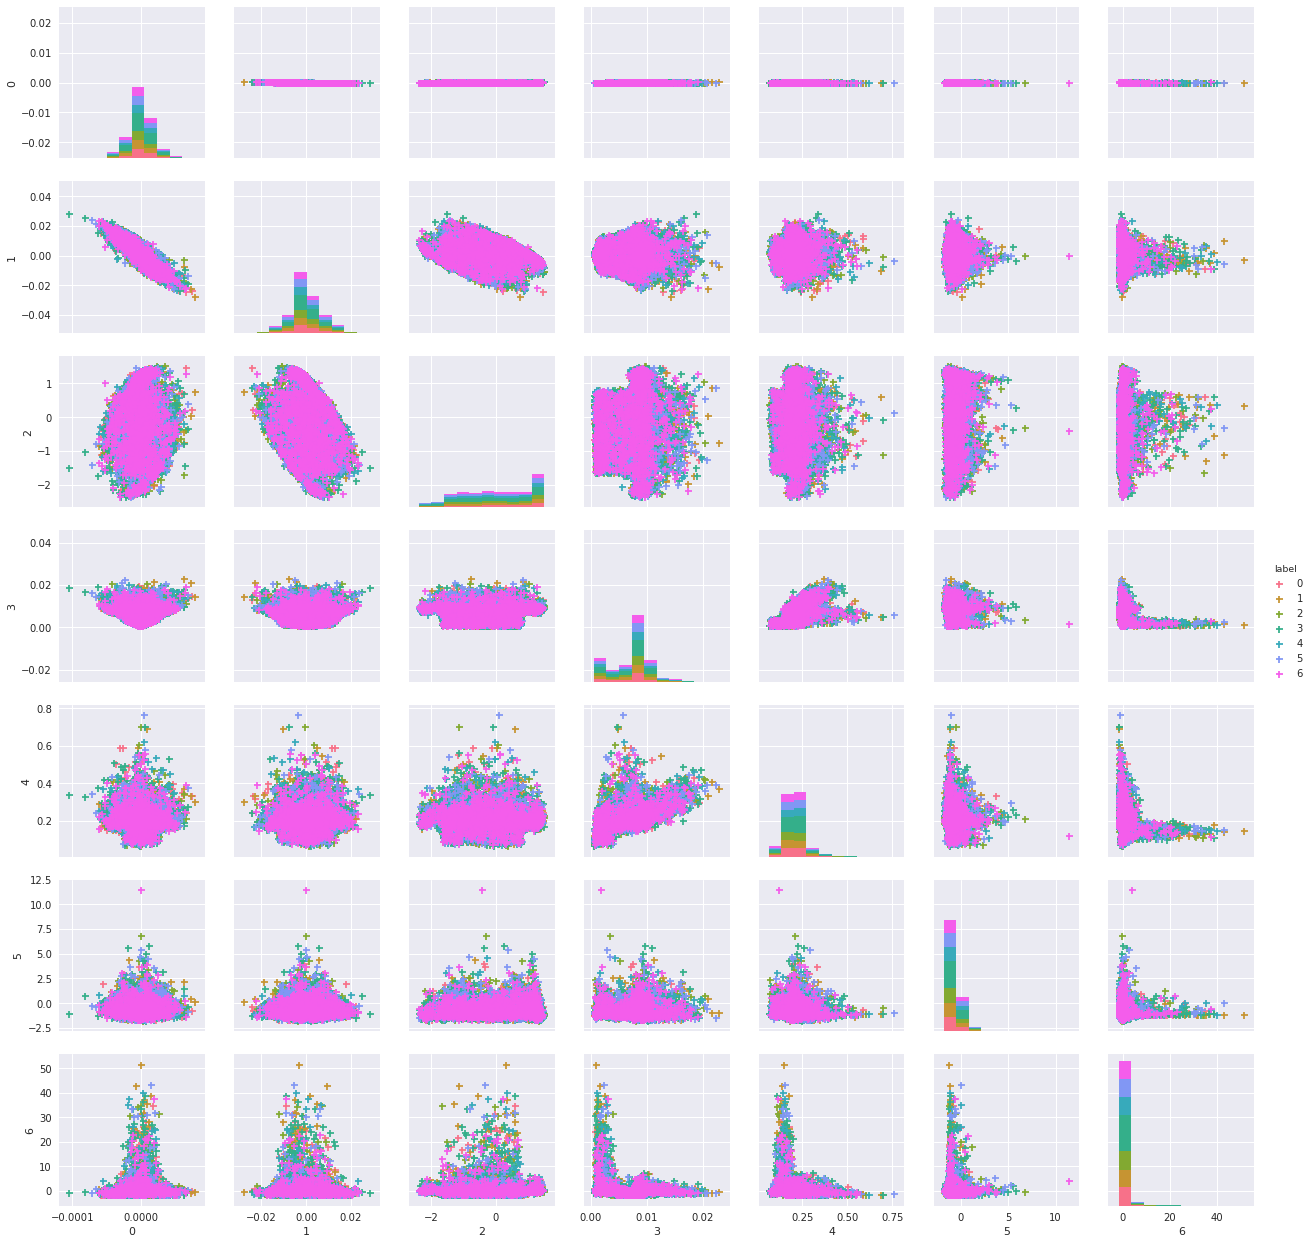

In [27]:
featureCols = trainFeaturesDF.columns[0:len(trainFeaturesDF.columns)-1]
sns.pairplot(trainFeaturesDF,vars=featureCols,hue='label',markers='+')
plt.show()

# Classifiying from trace features

## All classes (noise + 5 signal types)

In [22]:
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,4.0:3.0,5.0:4.0,6.0:5.0}
traceDataset_05_alpha = cu.datautils.loadDataset('../data/traceDataset_0.5alpha.hdf5',subsetClasses=subsetClasses)

# Make a dataset with features extracted
featuresDataset = buildFeaturesDataset(traceDataset_05_alpha)

Dim of data: 256
Number of training images = 10588
Number of validation images = 2097
Number of test images = 1300
Distribution in training data:
0 - 1526
1 - 1531
2 - 3018
3 - 1503
4 - 1509
5 - 1501
Distribution in validation data:
0 - 287
1 - 281
2 - 628
3 - 303
4 - 302
5 - 296
Distribution in test data:
0 - 185
1 - 185
2 - 349
3 - 192
4 - 186
5 - 203


In [89]:
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,4.0:3.0,5.0:4.0,6.0:5.0}
traceDataset_01_alpha = cu.datautils.loadDataset('../data/traceDataset_0.1alpha.hdf5',subsetClasses=subsetClasses)
traceDataset_05_alpha = cu.datautils.loadDataset('../data/traceDataset_0.5alpha.hdf5',subsetClasses=subsetClasses)

# Make a dataset with features extracted
featuresDataset = buildFeaturesDataset([traceDataset_01_alpha,traceDataset_05_alpha])

## Parameter search for SVM
C_values = 10**np.random.uniform(1,5,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = cu.modelutils.runLinSVMModel(featuresDataset,C_val,printReports=False,modeltype='rbfSVM',gamma='auto')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print("Results for C={}:".format(C_val))
    print("Train score={}   Test score={}".format(a['train_score'],a['test_score']))

Dim of data: 256
Number of training images = 10588
Number of validation images = 2097
Number of test images = 1300
Distribution in training data:
0 - 1526
1 - 1531
2 - 3018
3 - 1503
4 - 1509
5 - 1501
Distribution in validation data:
0 - 287
1 - 281
2 - 628
3 - 303
4 - 302
5 - 296
Distribution in test data:
0 - 185
1 - 185
2 - 349
3 - 192
4 - 186
5 - 203
Dim of data: 256
Number of training images = 10588
Number of validation images = 2097
Number of test images = 1300
Distribution in training data:
0 - 1526
1 - 1531
2 - 3018
3 - 1503
4 - 1509
5 - 1501
Distribution in validation data:
0 - 287
1 - 281
2 - 628
3 - 303
4 - 302
5 - 296
Distribution in test data:
0 - 185
1 - 185
2 - 349
3 - 192
4 - 186
5 - 203
[LibSVM]Results for C=11.8649582467:
Train score=0.141764261428   Test score=0.156153846154
[LibSVM]Results for C=117.210286471:
Train score=0.425576123914   Test score=0.436923076923
[LibSVM]Results for C=1090.51607254:
Train score=0.47997733283   Test score=0.486153846154
[LibSVM]Resul

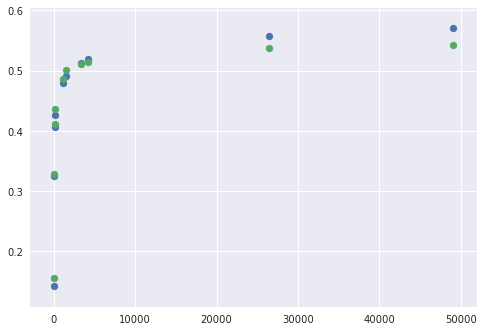

In [90]:
plt.scatter(C_values,train_scores)
plt.scatter(C_values,test_scores)
plt.show()

In [92]:
C_val = 50000.0
a = cu.modelutils.runLinSVMModel(featuresDataset,C_val,printReports=True,modeltype='rbfSVM',gamma='auto')

[LibSVM]             precision    recall  f1-score   support

        0.0       0.38      0.94      0.54      1526
        1.0       0.55      0.67      0.61      1531
        2.0       0.85      0.51      0.64      3018
        3.0       0.72      0.65      0.68      1503
        4.0       0.65      0.39      0.49      1509
        5.0       0.55      0.32      0.40      1501

avg / total       0.65      0.57      0.57     10588

[[1441    0    1    0   22   62]
 [ 199 1033  148  115   19   17]
 [ 461  751 1536  184   37   49]
 [ 326   75   61  975   19   47]
 [ 638   14   45   19  583  210]
 [ 738    1   12   64  212  474]]
             precision    recall  f1-score   support

        0.0       0.37      0.94      0.53       185
        1.0       0.53      0.71      0.61       185
        2.0       0.84      0.48      0.61       349
        3.0       0.69      0.56      0.62       192
        4.0       0.64      0.44      0.52       186
        5.0       0.49      0.22      0.31     

In [58]:
sum(model_pred==2.0)

221

In [57]:
## Saving misclassifications
x_test_norm = featuresDataset['x_test']
x_test_norm -= np.mean(featuresDataset['x_train'],axis=0)
x_test_norm /= (np.std(featuresDataset['x_train'],axis=0)+1e-3)
model_pred = a['lin_clf'].predict(x_test_norm)
imgPath = "../data/welch_specdataimages_gray_256x512_6/"
savePath = "./pathTraceMisclassifications/"
os.system("mkdir -p {}".format(savePath))
for i in range(len(model_pred)):
    if model_pred[i] == 4 and featuresDataset['y_test'][i] != 4:
        imgid = featuresDataset['test_ids'][i]
        source = "{}{}.jpg".format(imgPath,imgid)
        dest = "{}p{}c{}_{}.jpg".format(savePath,model_pred[i],int(featuresDataset['y_test'][i]),imgid)
        os.system("cp {} {}".format(source,dest))

## Signal classes

In [16]:
#subsetClasses = {2.0:0.0,3.0:1.0,4.0:2.0,5.0:3.0,6.0:4.0}
subsetClasses = {0.0:0.0,2.0:1.0,3.0:1.0,4.0:1.0,5.0:1.0,6.0:1.0}
traceDataset_05_alpha = cu.datautils.loadDataset('../data/traceDataset_0.5alpha.hdf5',subsetClasses=subsetClasses)

# Make a dataset with features extracted
featuresDataset = buildFeaturesDataset(traceDataset_05_alpha)

## Parameter search for SVM
C_values = 10**np.random.uniform(1,4,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = cu.modelutils.runLinSVMModel(featuresDataset,C_val,printReports=False,modeltype='rbfSVM',gamma='auto')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print("Results for C={}:".format(C_val))
    print("Train score={}   Test score={}".format(a['train_score'],a['test_score']))

Dim of data: 256
Number of training images = 10588
Number of validation images = 2097
Number of test images = 1300
Distribution in training data:
0 - 1526
1 - 9062
Distribution in validation data:
0 - 287
1 - 1810
Distribution in test data:
0 - 185
1 - 1115
[LibSVM]Results for C=1386.4525156:
Train score=0.679637325274   Test score=0.683846153846
[LibSVM]Results for C=659.154696821:
Train score=0.669437098602   Test score=0.673076923077
[LibSVM]Results for C=1523.86511511:
Train score=0.681715149226   Test score=0.686153846154
[LibSVM]Results for C=4723.17325403:
Train score=0.694370986022   Test score=0.693076923077
[LibSVM]Results for C=82.3160203009:
Train score=0.717321496033   Test score=0.725384615385
[LibSVM]Results for C=14.9220537427:
Train score=0.70476010578   Test score=0.700769230769
[LibSVM]Results for C=575.597896735:
Train score=0.666887041934   Test score=0.67
[LibSVM]Results for C=3374.52762228:
Train score=0.691159803551   Test score=0.692307692308
[LibSVM]Results fo

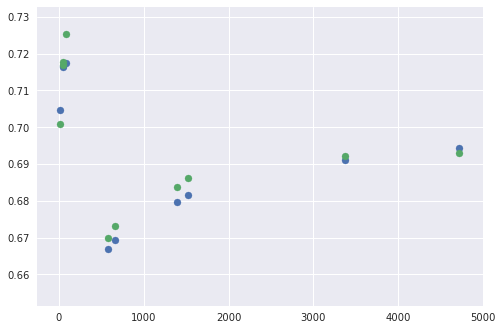

In [17]:
plt.scatter(C_values,train_scores)
plt.scatter(C_values,test_scores)
plt.show()

In [18]:
C_val = 43.2
a = cu.modelutils.runLinSVMModel(featuresDataset,C_val,printReports=True,modeltype='rbfSVM',gamma='auto')

[LibSVM]             precision    recall  f1-score   support

        0.0       0.31      0.79      0.44      1526
        1.0       0.95      0.70      0.81      9062

avg / total       0.86      0.72      0.76     10588

[[1201  325]
 [2675 6387]]
             precision    recall  f1-score   support

        0.0       0.31      0.81      0.45       185
        1.0       0.96      0.70      0.81      1115

avg / total       0.87      0.72      0.76      1300

[[150  35]
 [332 783]]
Classification accuracy: 0.72
MSE: 0.28
